### Util

#### Ignore warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

#### Hot encode and decode

In [2]:
import numpy as np
from collections import OrderedDict
from operator import itemgetter


def myHotEncode(input_data, max_vocab=0, vocab2idx=None):
    "Return the hot-vecotor and the vocab2idx."
    if vocab2idx is None:
        vocabFreq = {}
        for i in input_data:
            for j in i:
                if j not in vocabFreq:
                    vocabFreq[j] = 0
                vocabFreq[j] += 1
        vocabFreq = OrderedDict(sorted(vocabFreq.items(), key=itemgetter(1), reverse=True))
        vocab2idx = {}
        count = 0
        for v in vocabFreq:
            count += 1
            if max_vocab > 0 and count > max_vocab:
                break
            vocab2idx[v] = len(vocab2idx)        
    vocabEmbeddings = np.identity(len(vocab2idx), dtype='float32')
    data_ret = []
    for i in input_data:
        i_ = []
        for j in i:
            if j in vocab2idx:
                i_.append(vocabEmbeddings[vocab2idx[j]])
        if len(i_) == 0:
            i_ = np.zeros((1,len(vocab2idx)))
        data_ret.append(sum(i_))
    return data_ret, vocab2idx


def myHotDecode(input_data, vocab2idx):
    "Return the decode as final representation and decode as indexs"
    data_ = []
    data_idx = []
    for i in input_data:
        i_ = []
        i_idx = []
        if len(i) != len(vocab2idx):
            print('Erro:', 'The vocab2idx not fit the input data!')
            return
        for _i, j in enumerate(i):
            if j > 0:
                v = [k for k in vocab2idx if vocab2idx[k]==_i][0]
                i_.append(v)
                i_idx.append(_i)
        data_.append(i_)
        data_idx.append(i_idx)
    return data_, data_idx

#### Treat a list of str

In [3]:
import re


def treat_str_list(input_list):
    ret = []
    for s in input_list:
        ret += [ss.lower().strip() for ss in re.split('[\W_]+', s)]
    return ret

#### Plot confusion matrix

In [4]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load data

In [69]:
import pandas as pd


data_path = 'features_annotated.csv'
df = pd.read_csv(data_path)

In [70]:
import ast


columns = ['attrs', 'label', 'level', 'tag', 'text', 'url']

last_url = ''
#batches = []

css_tss = []
id_tss = []
level_tss = []
tag_tss = []
url_tss = []
text_tss = []
css_ts = []
id_ts = []
level_ts = []
tag_ts = []
url_ts = []
text_ts = []

labels = []
#labels_batch = []
label = 'None'

last_level = -1
line = 0

for attr, label_, level, tag, text, url in df[columns].values:
    attr = ast.literal_eval(attr)
    if url != last_url:
        css_tss.append(css_ts.copy())
        id_tss.append(id_ts.copy())
        level_tss.append(level_ts.copy())
        tag_tss.append(tag_ts.copy())
        text_tss.append(text_ts.copy())
        url_tss.append(last_url)
        css_ts = []
        id_ts = []
        level_ts = []
        tag_ts = []
        text_ts = []
        #labels_batch.append(label)
        #aux_list = []
        #aux_list.append(css_tss.copy())
        #aux_list.append(id_tss.copy())
        #aux_list.append(level_tss.copy())
        #aux_list.append(tag_tss.copy())
        #batches.append(aux_list)
        #css_tss = []
        #id_tss = []
        #level_tss = []
        #tag_tss = []
        labels.append(label) # new
        #labels.append(labels_batch.copy())
        #labels_batch = []
        last_url = url
        label = 'None'
        line = 0
    if not level > last_level:
        css_tss.append(css_ts.copy())
        id_tss.append(id_ts.copy())
        level_tss.append(level_ts.copy())
        tag_tss.append(tag_ts.copy())
        text_tss.append(text_ts.copy())
        url_tss.append(last_url)
        css_ts = css_ts[:level]
        id_ts = id_ts[:level]
        level_ts = level_ts[:level]
        tag_ts = tag_ts[:level]
        text_ts = text_ts[:level]
        #labels_batch.append(label)
        labels.append(label) # new
        label = 'None'
    if label_ != 'None':
        label = label_
    # Features
    if 'class' in attr:
        css_ts.append(treat_str_list(attr['class']))
        #css_ts += treat_str_list(attr['class'])
    else:
        css_ts.append([])
    aux_list = []
    if 'id' in attr:
        #aux_list.append(treat_str_list([attr['id']]))
        aux_list += treat_str_list([attr['id']])
    if 'name' in attr:
        #aux_list.append(treat_str_list([attr['name']]))
        aux_list += treat_str_list([attr['name']])
        
    id_ts.append(aux_list)
    tag_ts.append([tag])
    level_ts.append([level, line])
    if text != 'NOT TEXT' and type(text) == str:
        # ToDo - append ( [len(text)] + TFIDF_vector  ). Perhaps in another code block
        #text_ts.append([len(text)])
        text_ts.append([len(text)] + [text])
    else:
        text_ts.append([0] + [''])
    last_level = level
    line += line
    
css_tss.append(css_ts.copy())
id_tss.append(id_ts.copy())
level_tss.append(level_ts.copy())
tag_tss.append(tag_ts.copy())
text_tss.append(text_ts.copy())
url_tss.append(last_url)
#labels_batch.append(label)
#aux_list = []
#aux_list.append(css_tss.copy())
#aux_list.append(id_tss.copy())
#aux_list.append(level_tss.copy())
#aux_list.append(tag_tss.copy())
#batches.append(aux_list)
#labels.append(labels_batch.copy())
labels.append(label) # new
#batches = batches[1:]
css_tss = css_tss[1:] # new
id_tss = id_tss[1:] # new
level_tss = level_tss[1:] # new
tag_tss = tag_tss[1:] # new
text_tss = text_tss[1:] # new
url_tss = url_tss[1:] # new
labels = labels[1:]

### Mapping the features

In [71]:
css_ = []
id_ = []
tag_ = []
text_ = []
for css in css_tss:
    for i in css:
        css_.append(i)
for _id in id_tss:
    for i in _id:
        id_.append(i)
for tag in tag_tss:
    for i in tag:
        tag_.append(i)
for text in text_tss:
    for i in text:
        if i[1] != '':
            text_.append(i[1])
_, css2Idx = myHotEncode(css_, 100)
_, id2Idx = myHotEncode(id_, 100)
_, tag2Idx = myHotEncode(tag_, 100)

In [72]:
#for i0, batch in enumerate(batches):
# CSS classes
for i1, sample in enumerate(css_tss):
    sample_, _ = myHotEncode(sample, vocab2idx=css2Idx)
    css_tss[i1] = sample_
# ID and Names
for i1, sample in enumerate(id_tss):
    sample_, _ = myHotEncode(sample, vocab2idx=id2Idx)
    id_tss[i1] = sample_
# Tags
for i1, sample in enumerate(tag_tss):
    sample_, _ = myHotEncode(sample, vocab2idx=tag2Idx)
    tag_tss[i1] = sample_
css_tss = np.array(css_tss)
id_tss = np.array(id_tss)
level_tss = np.array(level_tss)
tag_tss = np.array(tag_tss)
text_tss = np.array(text_tss)
url_tss = np.array(url_tss)

### TF-IDF

In [73]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


vocab_size = 1000
vec = TfidfVectorizer(max_features=vocab_size, stop_words=ENGLISH_STOP_WORDS)
vec.fit(text_)

for i, text in enumerate(text_tss):
    for j, t in enumerate(text):
        text_tss[i][j] = np.concatenate(([t[0]], vec.transform([t[1]]).toarray()[0]))

Wall time: 12 s


### Pad the data

In [59]:
from keras.preprocessing.sequence import pad_sequences


css_tss = pad_sequences(css_tss, maxlen=10)
id_tss = pad_sequences(id_tss, maxlen=10)
level_tss = pad_sequences(level_tss, maxlen=10)
tag_tss = pad_sequences(tag_tss, maxlen=10)
text_tss = pad_sequences(text_tss, maxlen=10)

### Mapping the output

In [60]:
labels, label2Idx = myHotEncode([[l] for l in labels])
labels = np.array(labels)

## Model

In [68]:
from keras.models import Model, Sequential
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate,Concatenate


def lstm_model():
    input_css = Input(shape=(None, len(css2Idx)), name='input_css')
    css = LSTM(len(css2Idx), return_sequences=True, name='lstm_css')(input_css)
    
    input_id = Input(shape=(None, len(id2Idx)), name='input_id')
    _id = LSTM(len(id2Idx), return_sequences=True, name='lstm_id')(input_id)
    
    input_level = Input(shape=(None, 2), name='input_level')
    level = LSTM(4, return_sequences=True, name='lstm_level')(input_level)
    
    input_tag = Input(shape=(None, len(tag2Idx)), name='input_tag')
    tag = LSTM(len(tag2Idx), return_sequences=True, name='lstm_tag')(input_tag)
    
    input_text = Input(shape=(None, (1+vocab_size)), name='input_text')
    text = LSTM((1+vocab_size), return_sequences=True, name='lstm_text')(input_text)
    
    output = concatenate([css, _id, level, tag, text], name='concat_inputs')
    output = LSTM(256, name='lstm_concat')(output)
    output = Dense(len(label2Idx), activation='softmax', name='dense_output')(output)
    
    model = Model(inputs=[input_css, input_id, input_level, input_tag, input_text], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='nadam')
    #model.summary()
    return model

def lstm_model_old():
    input_css = Input(shape=(None, len(css2Idx)), name='input_css')
    css = LSTM(len(css2Idx), name='lstm_css')(input_css)
    
    input_id = Input(shape=(None, len(id2Idx)), name='input_id')
    _id = LSTM(len(id2Idx), name='lstm_id')(input_id)
    
    input_level = Input(shape=(None, 1), name='input_level')
    level = LSTM(1, name='lstm_level')(input_level)
    
    input_tag = Input(shape=(None, len(tag2Idx)), name='input_tag')
    tag = LSTM(len(tag2Idx), name='lstm_tag')(input_tag)
    
    output = concatenate([css, _id, level, tag], name='concat_inputs')
    output = Dense(256, name='dense_concat')(output)
    output = Dense(len(label2Idx), activation='softmax', name='dense_output')(output)
    model = Model(inputs=[input_css, input_id, input_level, input_tag], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='nadam')
    #model.summary()
    return model

## Test

In [67]:
%%time
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

# Aux print
_, url2Idx = myHotEncode([[u] for u in url_tss])

gp = GroupKFold(n_splits=5)
for train_indexs, test_indexs in gp.split(tag_tss, groups=url_tss):
    
    css_train = css_tss[train_indexs]
    id_train = id_tss[train_indexs]
    level_train = level_tss[train_indexs]
    tag_train = tag_tss[train_indexs]
    text_train = text_tss[train_indexs]
    
    X_train = [css_train, id_train, level_train, tag_train, text_train]
    y_train = labels[train_indexs]
    
    css_test = css_tss[test_indexs]
    id_test = id_tss[test_indexs]
    level_test = level_tss[test_indexs]
    tag_test = tag_tss[test_indexs]
    text_test = text_tss[test_indexs]
    
    X_test = [css_test, id_test, level_test, tag_test, text_test]
    y_test = labels[test_indexs]

    groups_train = url_tss[train_indexs]
    groups_test = url_tss[test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(url2Idx[g])
    for g in groups_test:
        test_g.add(url2Idx[g])
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    model = KerasClassifier(build_fn=lstm_model)
    model.fit(X_train, y_train, epochs=60, verbose=1)
    #model.fit(tags_train, y_train, epochs=5, verbose=0)

    result = model.predict(X_test)
    #result = model.predict(tags_test)
    y_test = [r.tolist().index(1) for r in y_test]
    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    confusion.append(confusion_matrix(result, y_test))
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

Train Groups (URLs) {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13}
Test Groups (URLs) {0, 12}
Epoch 1/60
3532/3532 [==============================] - 21s 6ms/step - loss: 0.3290
Epoch 2/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.1863
Epoch 3/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.2252
Epoch 4/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.1380
Epoch 5/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.1167
Epoch 6/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.1070
Epoch 7/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.0917
Epoch 8/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.0842
Epoch 9/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.0818
Epoch 10/60
3532/3532 [==============================] - 13s 4ms/step - loss: 0.0743
Epoch 11/60
3532/3532 [==============================] - 13s 4ms/step - 

KeyboardInterrupt: 

### Plot confusion matrix

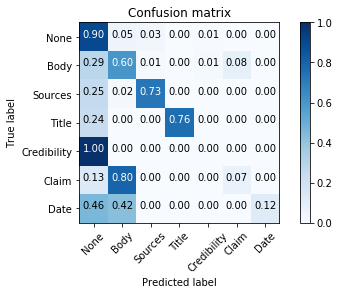

In [63]:
nc = []
for c in confusion:
    d = len(label2Idx) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, label2Idx.keys(), normalize=True)